# Autoencoder for Ultrasound Images

In this notebook, we demonstrate how to use the [TAESD](https://github.com/madebyollin/taesd) tiny autoencoder model for ultrasound images using the `zea` toolbox. We'll encode and decode images, visualize the results, and try a simple experiment: interpolating (traveling) in the latent space between two images and animating the result. Note that this model was trained purely on image data, and not finetuned on ultrasound data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/taesd_autoencoder_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/taesd_autoencoder_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/taesdxl)

In [ ]:
%%capture
%pip install zea

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras import ops
from matplotlib import animation
from IPython.display import HTML


import zea
from zea import init_device
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.models.taesd import TinyAutoencoder
from zea.visualize import plot_image_grid, set_mpl_style

zea: Using backend 'tensorflow'


We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [3]:
init_device(verbose=False)
set_mpl_style()

## Load data

We load a small batch from the CAMUS validation dataset hosted on Hugging Face Hub.

In [4]:
n_imgs = 4
val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image",
    batch_size=n_imgs,
    shuffle=True,
    image_size=[256, 256],
    resize_type="resize",
    image_range=[-60, 0],
    normalization_range=[-1, 1],
    seed=42,
)
batch = next(iter(val_dataset))

zea: Using pregenerated dataset info file: /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 13, 2025
zea: Remove /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.
zea: H5Generator: Shuffled data.


## Load TAESD Model

We use the built-in TAESD model from `zea`.

In [5]:
model = TinyAutoencoder.from_preset("taesdxl")

## Encode and Decode

We encode and decode the images using the autoencoder. TAESD expects grayscale or RGB, so we keep the input as is.

In [6]:
recon = model(batch)
mse = ops.convert_to_numpy(ops.mean((recon - batch) ** 2))
print("MSE (reconstruction):", mse)

MSE (reconstruction): 0.00917655


## Visualization

We plot the original images and reconstructions for comparison.

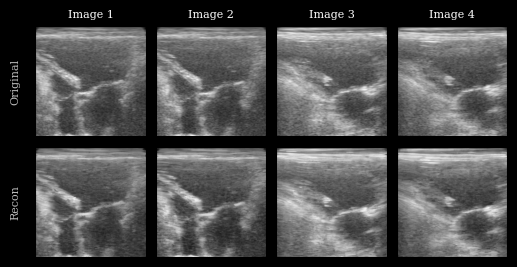

In [11]:
imgs = [zea.display.to_8bit(batch[i], (-1, 1), pillow=False) for i in range(n_imgs)] + [
    zea.display.to_8bit(recon[i], (-1, 1), pillow=False) for i in range(n_imgs)
]

titles = [f"Image {i + 1}" for i in range(n_imgs)]

fig, _ = plot_image_grid(
    imgs,
    ncols=n_imgs,
    remove_axis=False,
    figsize=(n_imgs * 2, 3),
)
for i, ax in enumerate(fig.axes[:n_imgs]):
    ax.set_title(titles[i], fontsize=8)
fig.axes[0].set_ylabel("Original", fontsize=8)
fig.axes[n_imgs].set_ylabel("Recon", fontsize=8)
plt.show()

## Latent Space Interpolation

Let's pick two images, encode them, and interpolate between their latent representations. We'll decode each interpolated latent and animate the result to visualize a smooth transition between two ultrasound images. Again, note that this model was trained on natural images only, and improved results are expected with a finetuned model on ultrasound data (to be added!).

In [8]:
# Pick two images to interpolate between
img_a = batch[0][None, ...]
img_b = batch[2][None, ...]

latent_a = model.encode(img_a)
latent_b = model.encode(img_b)

n_steps = 24
alphas = np.linspace(0, 1, n_steps)
frames = []
for alpha in alphas:
    latent_interp = (1 - alpha) * latent_a + alpha * latent_b
    recon_interp = model.decode(latent_interp)
    frames.append(zea.display.to_8bit(recon_interp[0], (-1, 1), pillow=False))

fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap="gray", vmin=0, vmax=255)
ax.axis("off")


def animate(i):
    im.set_data(frames[i])
    return [im]


ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=80, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

You should see a smooth morphing between two ultrasound images, demonstrating the structure of the TAESD latent space.